In [1]:
import shapely.wkt as sw
import shapely
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections
import os.path

In [2]:
def calc_format(polygon):
    vertices = polygon.exterior.coords[:-1]
    langles = []
    n = len(vertices)
    v1 = (vertices[1][0] - vertices[0][0], vertices[1][1] - vertices[0][1])
    v2 = (vertices[-1][0] - vertices[0][0], vertices[-1][1] - vertices[0][1])
    angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
    langles.append(angle)
    for i in range(1,n-1):
        v1 = (vertices[i+1][0] - vertices[i][0], vertices[i+1][1] - vertices[i][1])
        v2 = (vertices[i-1][0] - vertices[i][0], vertices[i-1][1] - vertices[i][1])
        angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
        langles.append(angle)
    v1 = (vertices[0][0] - vertices[n-1][0], vertices[0][1] - vertices[n-1][1])
    v2 = (vertices[n-2][0] - vertices[n-1][0], vertices[n-2][1] - vertices[n-1][1])
    angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
    langles.append(angle)
    langles = [x+2*math.pi if x<0 else x for x in langles]
    # angles in degrees
    dlangles = [angle*180/math.pi for angle in langles]
    
    # TODO: optimize, maybe return full length (big triangle - building, small triangle - noise)
    ledges = []
    for i in range(1,n):
        l = math.sqrt((vertices[i][0] - vertices[i-1][0])**2 + (vertices[i][1] - vertices[i-1][1])**2)
        ledges.append(l)
    l = math.sqrt((vertices[0][0] - vertices[n-1][0])**2 + (vertices[0][1] - vertices[n-1][1])**2)
    ledges.append(l)
    # scaled
    C = sum(ledges)
    sledges = [edge/C for edge in ledges]
    if len(ledges) != len(langles):
        raise Exception("Wrong number of components, bad calculation!")
    return [langles,sledges]

In [3]:
def angle_edge_format(geometry):
    polygons = []
    for geom in geometry:
        if isinstance(geom, shapely.geometry.multipolygon.MultiPolygon):
            for i in range(len(geom)):
                polygons.append(calc_format(geom[i]))
            # uncomment if intented to group multipolygons
            # multi = []
            # for i in range(len(geom)):
            #     multi.append(calc_format(geom[i]))
            # polygons.append(multi)
            #print("1 - {}".format(np.array(multi).shape))
        else:
            polygons.append(calc_format(geom))
            # uncomment if intented to group multipolygons
            # polygons.append([calc_format(geom)])
            #print("2 - {}".format(np.array([calc_format(geom)]).shape))
    return polygons

In [4]:
def test_dim(testlist, dim=0):
   if isinstance(testlist, list):
      if testlist == []:
          return dim
      dim = dim + 1
      dim = test_dim(testlist[0], dim)
      return dim
   else:
      if dim == 0:
          return -1
      else:
          return dim

In [5]:
def fix_single_class(X, edgeno):
    # conv A to list<string> to become hashable
    ahash = [str(a[0]) for a in edgeno.tolist()]
    # make hashable
    count = collections.Counter(ahash)
    # sorted key list
    scount = [int(a) for a in sorted(count, key=lambda x : int(x))]
    
    for i in range(len(edgeno)):
        #print(count[str(A[i,0])])
        if count[str(edgeno[i,0])] == 1:
            nscount = len(scount)
            # print(A[i,0])
            si = scount.index(edgeno[i,0])
            if si == 0:
                count[str(scount[1])] += 1
                edgeno[i,0] = scount[1]
            elif si == nscount-1:
                count[str(scount[-2])] += 1
                edgeno[i,0] = scount[-2]
            elif abs(si - scount[si-1]) <= abs(si - scount[si+1]):
                count[str(scount[si-1])] += 1
                edgeno[i,0] = scount[si-1]
            else:
                count[str(scount[si+1])] += 1
                edgeno[i,0] = scount[si+1]
            count.pop(str(scount[si]))
            scount.pop(si)
            nscount-=1
            # print(A[i,0], A[i])
            # print('------')
    
    return np.hstack((X,edgeno))
    # Debugging
    # print(f'In f: {X.shape}')
    # nahash = [str(a[0]) for a in A.tolist()]
    # ncount = collections.Counter(nahash)
    # print(ncount)
    # print(poly)

In [6]:
# reading data from file
geometry = []

with open('K2_buildings.tsv', 'r') as f:
    i = 0
    for line in f:
        geometry.append(sw.loads(line))
        i+=1
        if i == 5000:
            break
    
print("Number of polygons {}.".format(len(geometry)))    

Number of polygons 5000.


In [7]:
# making feature arrays
polygons = angle_edge_format(geometry)
poly = np.array(polygons)
# print("--------------------------------------------------------------------")
# for i in range(100):
#     print(f'Testidim: {test_dim(polygons[i])} - {np.array(polygons[i]).shape}')

In [8]:
# extracting angles and their min, max
angles = np.hstack(poly[:,0])
min_angle = np.min(angles)
max_angle = np.max(angles)
print("Min angle: {} rad {} deg \n Max angle: {} rad {} deg".format(min_angle, min_angle*180/math.pi, max_angle, max_angle*180/math.pi))

Min angle: 0.0012746198074969906 rad 0.07303033545335501 deg 
 Max angle: 6.201088044501634 rad 355.2961733389765 deg


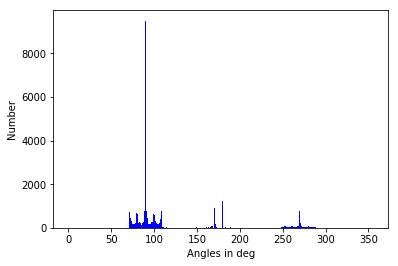

In [9]:
# angle distribution histogram
num_bins = 360
n, bins, patches = plt.hist(angles*180/math.pi,num_bins,color='blue')
#plt.plot(bins)
plt.xlabel("Angles in deg")
plt.ylabel("Number")
plt.show()

In [10]:
# add number of edges column
n_edge = np.array([len(p) for p in poly[:,0]])
n_edge = n_edge.reshape((n_edge.shape[0],1))
poly = np.hstack((poly,n_edge))

(5206, 1)


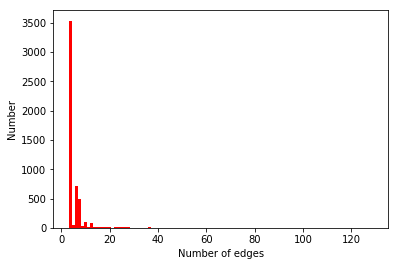

In [11]:
# histogram of number of edges
num_bins = 100
strat_edgeno = poly[:,2].copy()
strat_edgeno = strat_edgeno.reshape(strat_edgeno.shape[0],1)
print(strat_edgeno.shape)
n, bins, patches = plt.hist(strat_edgeno, num_bins, color='red')
#plt.plot(bins)
plt.xlabel("Number of edges")
plt.ylabel("Number")
plt.show()

In [12]:
poly = fix_single_class(poly, strat_edgeno)
#print(f'Out of f: {poly.shape}')

In [13]:
# random labels
prob = [0.3, 0.7]
y = np.random.choice([0,1], size=(poly.shape[0],1), p=prob)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(poly, y, test_size=0.33, stratify=poly[:,3])
print(f'X_Train: {X_train.shape}\nX_test: {X_test.shape}\nytrain: {y_train.shape}\nytest: {y_test.shape}')

X_Train: (3488, 4)
X_test: (1718, 4)
ytrain: (3488, 1)
ytest: (1718, 1)


In [17]:
del polygons
del poly
del strat_edgeno
del y